In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figure').absolute()

df_meta_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' /  'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_meta_path)

In [5]:
import palettable

ppi_colors = palettable.colorbrewer.qualitative.Set1_9.mpl_colors

# Viz images

In [6]:
def plot_spot_on_image(reference, spots, spacing, radius):
    spot_img = np.zeros_like(reference)
    coords = (spots[:, :3] / spacing).astype(int)
    r = radius  # shorthand
    for coord in coords:
        slc = tuple(slice(x-r, x+r) for x in coord)
        spot_img[slc] = 1
    return spot_img

In [7]:
df_imgs

,Timepoint,FOV,Path
0,HCC827Ctrl,FW1,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
1,HCC827Ctrl,FW2,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
2,HCC827Osim,FW1,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
3,HCC827Osim,FW2,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...


In [8]:
path = df_imgs.iloc[0].Path

In [9]:
with h5py.File(path, "r") as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']

In [11]:
napari.view_image(imgs, channel_axis=0, name=markers, visible=False, contrast_limits=[0,1])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 1720.5, 4301.0), zoom=0.0895169514510442, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1, 1), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 3442.0, 1.0), (0.0, 8603.0, 1.0)), current_step=(1721, 4301), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Hoeschst' at 0x22bca780eb0>, <Image layer 'Cyclin D1 & CDK2' at 0x22bca771280>, <Image layer 'NF-Kb & p-P90rsk' at 0x22bcaa466d0>, <Image layer 'Hoeschst [1]' at 0x22bcb1b1bb0>, <Image layer 'Sox2 & Oct4' at 0x22bcb1340d0>, <Image layer 'Bim & Tom20' at 0x22bcb2305b0>, <Image layer 'Hoeschst [2]' at 0x22bcb09aa90>, <Image layer 'Mcl-1 & BAK' at 0x22bcb382070>, <Image layer 'Hoeschst [3]' at 0x22bcb42c490>, <Image layer 'p-ERK & c-MYC' at 0x22bcb4d

# Viz PPI network

In [7]:
import networkx as nx

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

def get_contours(contours, key, cell):
    contour_cell = contours[key]['Cell'][int(cell)]
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax
    
def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    contour = max(contour_cell, key = len)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass

In [8]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib 
import scanpy

# Get encoder 
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)
df = df[df.PPI.isin(['Bim & Tom20', 'Cyclin D1 & CDK2', 'Cyclin E & CDK4', 'Mcl-1 & BAK', 'NF-Kb & p-P90rsk',
        'P-AKT & mTOR', 'Sox2 & Oct4', 'TEAD1 & YAP', 'p-ERK & c-MYC'])]

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
# colors = [ '#ff00ff', '#00FF00', '#FF0000',  '#00FFFF', '#FFFF00']
colors = ppi_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['Bim & Tom20', 'Cyclin D1 & CDK2', 'Cyclin E & CDK4',
       'Mcl-1 & BAK', 'NF-Kb & p-P90rsk', 'P-AKT & mTOR', 'Sox2 & Oct4',
       'TEAD1 & YAP', 'p-ERK & c-MYC'], dtype=object)]


In [8]:
df.head()

,Cyto,x,y,PPI,Nuclei,Condition,FOV,Labels
0,266,1925,7804,Cyclin D1 & CDK2,0,HCC827Ctrl,FW1,"[0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,65,790,810,Cyclin D1 & CDK2,0,HCC827Ctrl,FW1,"[0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,328,2667,2269,Cyclin D1 & CDK2,0,HCC827Ctrl,FW1,"[0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,328,2833,2164,Cyclin D1 & CDK2,0,HCC827Ctrl,FW1,"[0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,89,997,918,Cyclin D1 & CDK2,0,HCC827Ctrl,FW1,"[0, 1, 0, 0, 0, 0, 0, 0, 0]"


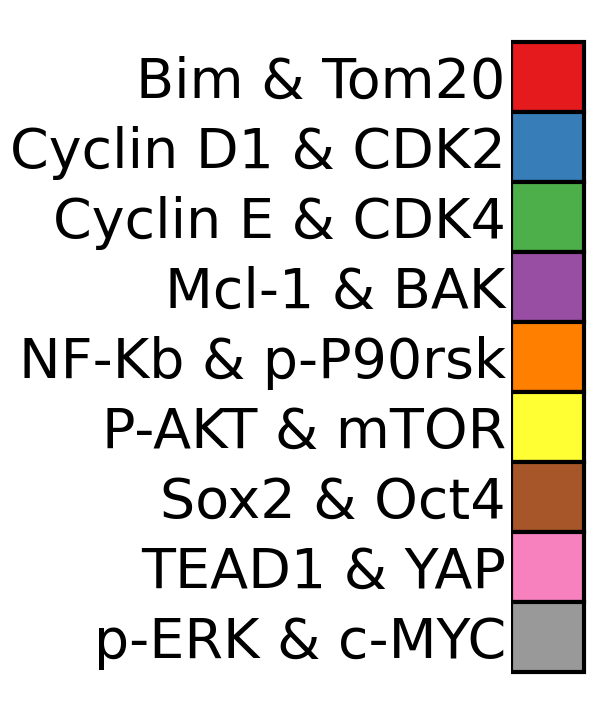

In [9]:
# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=40)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [79]:
import PLA

graph_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'graphs' / 'raw'
contour_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

Loading graphs
Loading contours


In [17]:
# Check if graph connected
df_subset = cell_data.df.sample(100)
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    
    if not nx.is_connected(network):
        print(row)
        
# Print existing node attributes in graph
node_attr = {k for attr_dict in network.nodes.data()._nodes.values() for k in attr_dict.keys()}
print(node_attr)

{'nuclei', 'pos', 'labels'}


# Plot Whole FOV PPI network

In [17]:
group = cell_data.df.groupby(['Condition', 'FOV'])

In [18]:
fig_path = fig_dir / 'PPI' / '9PPI Cell Culture' / 'Whole' / 'FOV'
fig_path.mkdir(parents=True, exist_ok=True)

In [20]:
# Loop through Condition FOV
for name, df_group in group:
    # Get imgs shape 
    path = df_imgs[(df_imgs.Timepoint == name[0]) & (df_imgs.FOV == name[1])].Path.item()
    with h5py.File(path, "r") as f:
        img_shape = f['imgs'].shape[1:]
    
    img_fov = np.zeros(img_shape)
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.imshow(img_fov, cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    ax.set_facecolor('k')

    # Get Individual cell
    for row in df_group.itertuples():
        key = '_'.join(row[1:3])
        cell = row[3]
        # Get contours
        contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
        contour = max(contour_cell, key = len)
        
        # Plot contours
        plot_contour(contour_cell, contour_nuclei, ax, linewidth=0.5)
        
        # Get graph
        network = read_pkl(row.Path)
        network.remove_edges_from(list(nx.selfloop_edges(network)))

        nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
        labels = list(nx.get_node_attributes(network, 'labels').values())
        labels = np.argmax(labels, axis=1)
        node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
        
        # Plot network
        plot_network(network,  node_colors, ax, node_size=1, linewidths=0, edgecolors='w', width=0.15, edge_color='w')
    
    file_name = '_'.join(name)
    fig.savefig(fig_path / f'{file_name}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()


# Plot with visual examples

In [9]:
from skimage.morphology import white_tophat as skimage_white_tophat
from copy import deepcopy

# Read images
def read_img_bbox(path, bbox, pad = 20):
    min_y, min_x, max_y, max_x = bbox
    min_y = np.clip(min_y - pad, a_min=0, a_max=None)
    min_x = np.clip(min_x - pad, a_min=0, a_max=None)
    max_y += pad
    max_x += pad
    
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][..., min_y:max_y, min_x:max_x]
    
    return imgs, markers

def white_tophat(image, radius):
        # ensure iterable radius
        if not isinstance(radius, (tuple, list, np.ndarray)):
            radius = (radius,)*image.ndim

        # convert to footprint shape
        shape = [2*r+1 for r in radius]

        # run white tophat
        return skimage_white_tophat(image, footprint=np.ones(shape))
    
    
def plot_contour_mean(contour_cell, contour_nuclei, offset, ax, linewidth=1):
    contour = deepcopy(max(contour_cell, key = len))
    contour -= np.array(offset)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = deepcopy(max(contour_nuclei, key = len))
        contour -= np.array(offset)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass
    
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

blue = LinearSegmentedColormap.from_list(
        "Blue", [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0]])

def plot_PPI(imgs, markers, contour_cell, contour_nuclei, offset, ax, 
             colors_rgb_dict=colors_rgb_dict, 
             q_min=0.9,
             q_max=0.998,
             subset=['Hoeschst', 'TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR', 'Mcl-1 & BAK'],
             DAPI = True):
    for i in range(len(subset)):
        indice = list(markers).index(subset[i])
        if i == 0 and DAPI:
            ax.imshow(imgs[indice], vmin=0, vmax=0.8, cmap=blue)
        else:
            # Get custom colormap 
            c_cmap = LinearSegmentedColormap.from_list("Blue", 
                                            [[0.0, 0.0, 0.0, 0.0], 
                                             np.array(list(colors_rgb_dict[subset[i]])+[255])/255])
            ax.imshow(imgs[indice], 
                      vmin=np.quantile(imgs[indice], q_min), 
                      vmax=np.quantile(imgs[indice], q_max), 
                      cmap=c_cmap)
    
    ax.axis('off')
    if contour_cell is not None:
        plot_contour_mean(contour_cell, contour_nuclei, offset, ax)

In [10]:
fig_path = fig_dir / 'PPI' / '9PPI Cell Culture' / 'Whole' / 'Cell'
fig_path.mkdir(parents=True, exist_ok=True)    

In [11]:
path = df_imgs.iloc[0].Path
with h5py.File(path, "r") as f:
    markers = f['imgs'].attrs['Marker']

In [22]:
subset1 = ['Hoeschst', 'Ki67', 'Pan-cytokeratin', 'p-EGFR', 'Concanavalin A']
subset2 = ['Hoeschst', 'NBD-C6', 'Golph4', 'COX IV', 'WGA']
PPI_subset = ['Cyclin D1 & CDK2', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4', 'Bim & Tom20',
              'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP', 'Cyclin E & CDK4', 'P-AKT & mTOR']

colors_rgb_dict_protein1 = {k:v for k,v in zip(subset1[1:], colors_rgb_dict.values())}
colors_rgb_dict_protein2 = {k:v for k,v in zip(subset2[1:], [list(colors_rgb_dict.values())[0], list(colors_rgb_dict.values())[2],
                                                             list(colors_rgb_dict.values())[3], list(colors_rgb_dict.values())[4]])}


In [ ]:
df_subset = cell_data.df

pad = 5
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]
    
    file_name = '_'.join([key, cell])
    if (fig_path / f'{file_name}.png').exists():
        continue
        
    # Get image path
    img_path = df_imgs[(df_imgs.FOV == row.FOV) & (df_imgs.Timepoint == row.Condition)].Path.item()
    
    # Get contours
    contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    contour = max(contour_cell, key = len)
    max_y, max_x = contour.max(axis=0).astype(int)
    min_y, min_x = contour.min(axis=0).astype(int)
    
    # Get mutiplex images
    img, markers = read_img_bbox(img_path, [min_y, min_x, max_y, max_x], pad=pad)
    img = white_tophat(img, 3)
    
    # Get graph
    network = read_pkl(row.Path)
    network.remove_edges_from(list(nx.selfloop_edges(network)))
    
    nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
    
    with plt.style.context('dark_background'):
        # Plot Graph
        f, axs = plt.subplots(1, 4, figsize=(16,4), facecolor='k')
        ax = axs[0]
        plot_network(network,  node_colors, ax, node_size=60, edgecolors='w', width=1.5, edge_color='w')
        plot_contour(contour_cell, contour_nuclei, ax, linewidth=1)
        ax.set_facecolor('k')

        ax=axs[1]
        ax.set_facecolor('k')
        plot_PPI(img, markers, contour_cell, contour_nuclei, offset=[min_y-pad, min_x-pad], 
                 subset=PPI_subset, ax=ax, DAPI=False)

        ax=axs[2]
        ax.set_facecolor('k')
        plot_PPI(img, markers, None, None, offset=[min_y-pad, min_x-pad], colors_rgb_dict=colors_rgb_dict_protein1,
                 subset = subset1,
                 q_min=0.002,
                 q_max=0.999,
                 ax=ax)

        ax=axs[3]
        ax.set_facecolor('k')
        plot_PPI(img, markers, None, None, offset=[min_y-pad, min_x-pad], colors_rgb_dict=colors_rgb_dict_protein2,
                 subset = subset2,
                 q_min=0.002,
                 q_max=0.999,
                 ax=ax)

        axs[0].invert_yaxis()
        axs[0].set_aspect('equal')
        f.set_facecolor("#00000F")
        f.subplots_adjust(wspace=0.01)
        f.suptitle(f'{key}_{cell}', fontsize=16, color='w')

        file_name = '_'.join([key, cell])
        f.savefig(fig_path / f'{file_name}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close()

In [40]:
# napari.view_image(img, channel_axis=0, name=markers, visible=False, contrast_limits=[0,1])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 74.5, 79.5), zoom=2.054375, angles=(0.0, 0.0, 90.0), perspective=0, interactive=True), cursor=Cursor(position=(1, 1), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 150.0, 1.0), (0.0, 160.0, 1.0)), current_step=(75, 80), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Hoeschst' at 0x22385587940>, <Image layer 'Cyclin D1 & CDK2' at 0x22385534be0>, <Image layer 'NF-Kb & p-P90rsk' at 0x223855ef1f0>, <Image layer 'Hoeschst [1]' at 0x2238c17b6d0>, <Image layer 'Sox2 & Oct4' at 0x2238d2a6bb0>, <Image layer 'Bim & Tom20' at 0x223906780d0>, <Image layer 'Hoeschst [2]' at 0x223907185b0>, <Image layer 'Mcl-1 & BAK' at 0x22392078a90>, <Image layer 'Hoeschst [3]' at 0x2239211c070>, <Image layer 'p-ERK & c-MYC' at 0x223921bb490>, <Image layer 'H

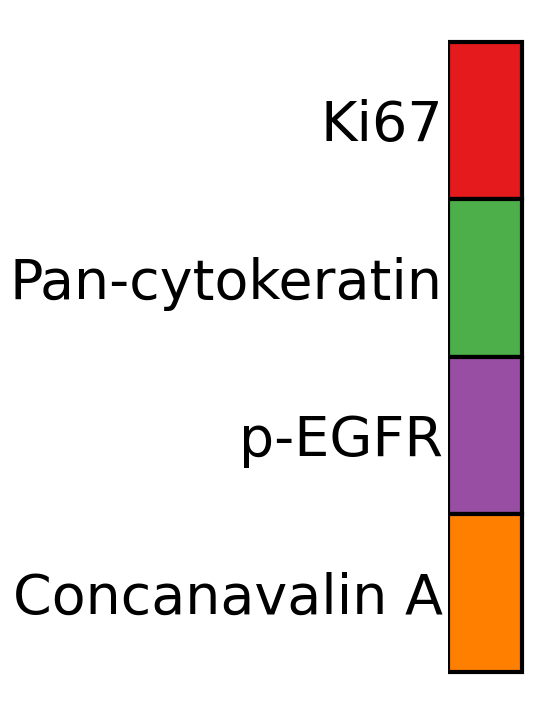

In [23]:
# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict_protein2.values())), 
        color=np.array(list(colors_rgb_dict_protein2.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict_protein2.values())), colors_rgb_dict_protein1.keys(), rotation=0, size=40)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [ ]:
# import napari

# napari.view_image(img, channel_axis=0, name=markers, visible=False)

# Coexpression